## AWS Outline for LDA

In [1]:
# Main libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
#from sklearn.metrics import accuracy_score, classification_reportt

### Importing Data

In [2]:
movie_data = pd.read_csv(r"/Users/krummelha/Desktop/J2024/Project2/wiki_movie_plots_deduped.csv")
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


Histogram 

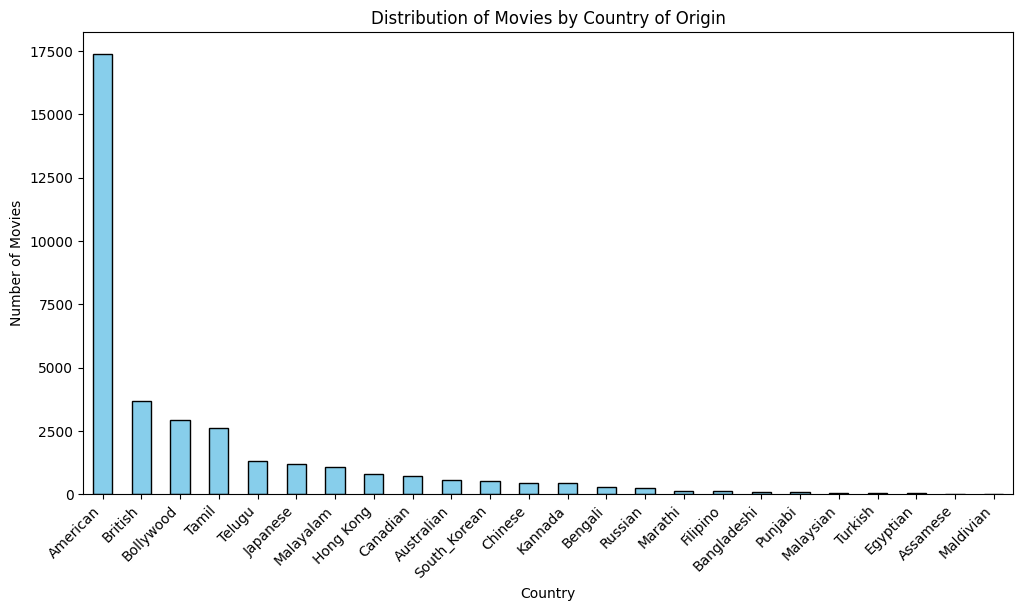

In [3]:
# Visualize the distribution of movies based on countries
plt.figure(figsize=(12, 6))
movie_data['Origin/Ethnicity'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Movies by Country of Origin')
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

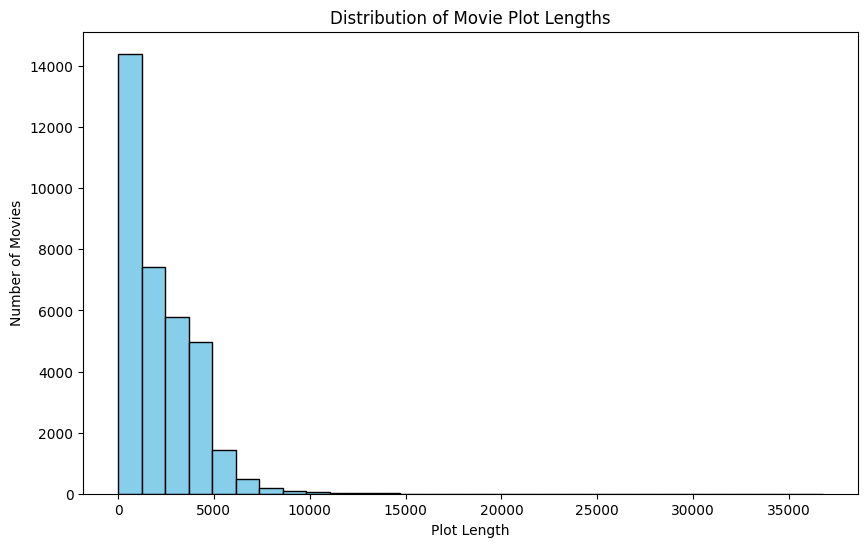

In [4]:
# Visualize the distribution of plot lengths
plt.figure(figsize=(10, 6))
plt.hist(movie_data['Plot'].str.len(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Plot Lengths')
plt.xlabel('Plot Length')
plt.ylabel('Number of Movies')
plt.show()

### Cleaning Data

In [5]:
# Select only films that are American in origin
us_movies = movie_data[movie_data['Origin/Ethnicity'] == 'American']

# Drop unwanted columns (Wiki.Page, Director, Cast)
us_movies = us_movies.drop(columns=['Wiki Page', 'Director', 'Cast'])

# Print the summary of the resulting DataFrame
us_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17377 entries, 0 to 17376
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      17377 non-null  int64 
 1   Title             17377 non-null  object
 2   Origin/Ethnicity  17377 non-null  object
 3   Genre             17377 non-null  object
 4   Plot              17377 non-null  object
dtypes: int64(1), object(4)
memory usage: 814.5+ KB


In [6]:
# Fetch Title and Plot columns
finaldata = us_movies[["Title", "Plot"]]

# Setting the movie title as index
finaldata = finaldata.set_index('Title')
finaldata.head()

,Plot
Title,
Kansas Saloon Smashers,"A bartender is working at a saloon, serving dr..."
Love by the Light of the Moon,"The moon, painted with a smiling face hangs ov..."
The Martyred Presidents,"The film, just over a minute long, is composed..."
"Terrible Teddy, the Grizzly King",Lasting just 61 seconds and consisting of two ...
Jack and the Beanstalk,The earliest known adaptation of the classic f...


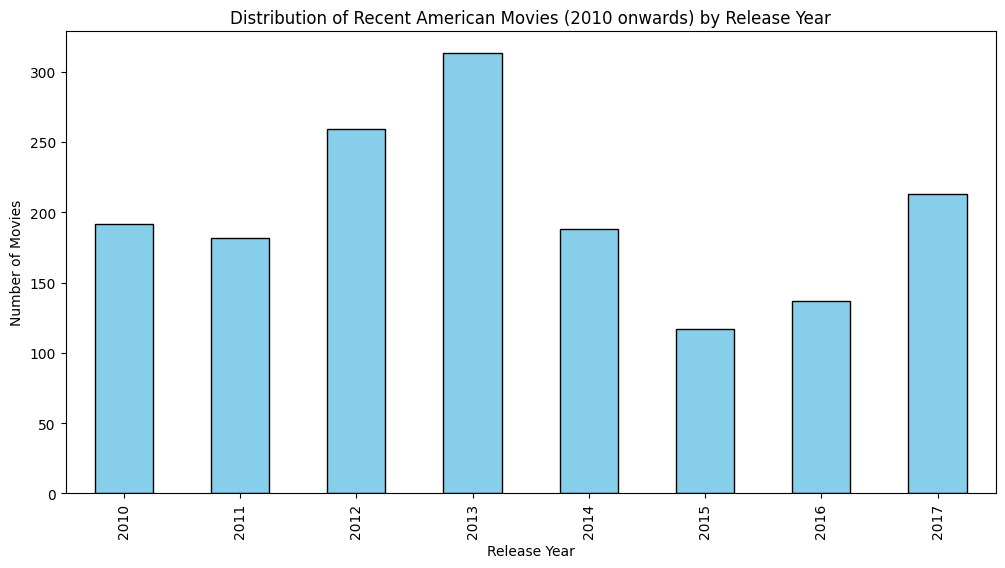

In [7]:
# Filter for recent years (e.g., from 2010 onwards)
recent_us_movies = us_movies[us_movies['Release Year'] >= 2010]

# Visualize the distribution of recent American movies by year
plt.figure(figsize=(12, 6))
recent_us_movies['Release Year'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Recent American Movies (2010 onwards) by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.show()



### Beginning LDA

In [8]:
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim


In [9]:
# create English stop words list
en_stop = get_stop_words('en')

In [10]:
print(en_stop)

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 't

In [11]:
tokenizer = RegexpTokenizer(r'\w+')

In [12]:
# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

In [13]:
plot_set = []
for item in finaldata["Plot"]:
    modified_item = item.replace("\'s", "")  # Corrected line
    plot_set.append(modified_item)

In [14]:
print(plot_set[0:1])

['A bartender is working at a saloon, serving drinks to customers. After he fills a stereotypically Irish man bucket with beer, Carrie Nation and her followers burst inside. They assault the Irish man, pulling his hat over his eyes and then dumping the beer over his head. The group then begin wrecking the bar, smashing the fixtures, mirrors, and breaking the cash register. The bartender then sprays seltzer water in Nation face before a group of policemen appear and order everybody to leave.[1]']


In [15]:
# List for tokenized plots in a loop
texts = []

In [16]:
# Names 

# Assuming your CSV file has a column named 'custom_stop_words'
# Adjust the file path and column name accordingly
csv_file_path = '/Users/krummelha/Desktop/J2024/Project2/names.csv'
names_df = pd.read_csv(csv_file_path)
names = names_df['name'].str.lower()
names = names.tolist()
print(names)

['smith', 'johnson', 'williams', 'brown', 'jones', 'miller', 'davis', 'garcia', 'rodriguez', 'wilson', 'martinez', 'anderson', 'taylor', 'thomas', 'hernandez', 'moore', 'martin', 'jackson', 'thompson', 'white', 'lopez', 'lee', 'gonzalez', 'harris', 'clark', 'lewis', 'robinson', 'walker', 'perez', 'hall', 'young', 'allen', 'sanchez', 'wright', 'king', 'scott', 'green', 'baker', 'adams', 'nelson', 'hill', 'ramirez', 'campbell', 'mitchell', 'roberts', 'carter', 'phillips', 'evans', 'turner', 'torres', 'parker', 'collins', 'edwards', 'stewart', 'flores', 'morris', 'nguyen', 'murphy', 'rivera', 'cook', 'rogers', 'morgan', 'peterson', 'cooper', 'reed', 'bailey', 'bell', 'gomez', 'kelly', 'howard', 'ward', 'cox', 'diaz', 'richardson', 'wood', 'watson', 'brooks', 'bennett', 'gray', 'james', 'reyes', 'cruz', 'hughes', 'price', 'myers', 'long', 'foster', 'sanders', 'ross', 'morales', 'powell', 'sullivan', 'russell', 'ortiz', 'jenkins', 'gutierrez', 'perry', 'butler', 'barnes', 'fisher', 'henders

In [17]:
## connecting the lists 
stop_words = en_stop + names



In [18]:
print(stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 't

In [19]:
# Tokenizing loop through plot list
for item in plot_set:
    
    # clean and tokenize document string
    raw = item.lower()
    tokens = tokenizer.tokenize(raw)

    # remove names and stop words from tokens
    #stopped_tokens = [item for item in tokens if item not in names and item not in en_stop]
    
    # remove names from tokens
    #stopped_tokens = [item for item in tokens if not item in names]

    # remove stop words from tokens
    stopped_tokens = [item for item in tokens if not item in stop_words]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(item) for item in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)

In [20]:
print(tokens)

['in', '1954', 'london', 'renowned', 'fashion', 'designer', 'reynolds', 'woodcock', 'creates', 'dresses', 'for', 'members', 'of', 'high', 'society', 'his', 'charisma', 'and', 'genius', 'are', 'matched', 'by', 'his', 'obsessive', 'controlling', 'and', 'sometimes', 'abusive', 'personality', 'cyril', 'his', 'sister', 'manages', 'the', 'day', 'to', 'day', 'operations', 'of', 'his', 'fashion', 'house', 'and', 'has', 'significant', 'influence', 'over', 'his', 'life', 'reynolds', 'is', 'haunted', 'by', 'the', 'death', 'of', 'their', 'mother', 'and', 'stitches', 'hidden', 'messages', 'into', 'the', 'linings', 'of', 'the', 'dresses', 'he', 'makes', 'after', 'designing', 'a', 'new', 'gown', 'for', 'a', 'revered', 'client', 'reynolds', 'visits', 'a', 'restaurant', 'in', 'the', 'countryside', 'and', 'becomes', 'interested', 'in', 'a', 'waitress', 'alma', 'he', 'asks', 'her', 'on', 'a', 'date', 'and', 'she', 'accepts', 'their', 'relationship', 'develops', 'and', 'she', 'moves', 'in', 'with', 'him',

In [21]:
print(texts[0:1])

[['bartend', 'work', 'saloon', 'serv', 'drink', 'custom', 'fill', 'stereotyp', 'irish', 'man', 'bucket', 'beer', 'carri', 'nation', 'follow', 'burst', 'insid', 'assault', 'irish', 'man', 'pull', 'hat', 'eye', 'dump', 'beer', 'head', 'group', 'begin', 'wreck', 'bar', 'smash', 'fixtur', 'mirror', 'break', 'cash', 'regist', 'bartend', 'spray', 'seltzer', 'water', 'nation', 'face', 'group', 'policemen', 'appear', 'order', 'everybodi', 'leav', '1']]


In [22]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)

In [23]:
print(dictionary)

Dictionary<63361 unique tokens: ['1', 'appear', 'assault', 'bar', 'bartend']...>


In [24]:
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

In [25]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.ldamodel import LdaModel

In [26]:
# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=13, id2word = dictionary, passes=20)

KeyboardInterrupt: 

In [ ]:
# print(ldamodel.print_topics(num_topics=13, num_words=4))

# how many topics do we want? 
# optimization graph - ensemble or something? hyperparameters, random forests 
# 

[(0, '0.011*"get" + 0.010*"game" + 0.009*"money" + 0.009*"team"'), (1, '0.006*"forc" + 0.006*"kill" + 0.006*"war" + 0.005*"use"'), (2, '0.016*"kill" + 0.011*"town" + 0.009*"billi" + 0.008*"men"'), (3, '0.014*"tell" + 0.013*"get" + 0.010*"leav" + 0.009*"car"'), (4, '0.010*"father" + 0.009*"famili" + 0.009*"mother" + 0.007*"year"'), (5, '0.027*"kill" + 0.016*"polic" + 0.013*"murder" + 0.008*"shoot"'), (6, '0.014*"jack" + 0.014*"film" + 0.009*"show" + 0.009*"mari"'), (7, '0.108*"mike" + 0.075*"johnni" + 0.073*"kate" + 0.038*"grace"'), (8, '0.058*"max" + 0.054*"jerri" + 0.039*"sam" + 0.036*"alic"'), (9, '0.107*"charli" + 0.056*"mark" + 0.053*"andi" + 0.025*"freddi"'), (10, '0.019*"dr" + 0.015*"kill" + 0.015*"harri" + 0.013*"jake"'), (11, '0.012*"tom" + 0.010*"find" + 0.009*"back" + 0.007*"tri"'), (12, '0.037*"joe" + 0.026*"ship" + 0.020*"island" + 0.019*"chri"')]


In [ ]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3543633981805143


In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 119
max_topics = 120
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
# if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('./lda_tuning_results1.csv', index=False)
    pbar.close()

  0%|          | 0/60 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(model_results).to_csv('./lda_tuning_results.csv', index=False)

In [ ]:
## Choosing number of topics 

num_topics_range = [75, 100, 125]
validation_perplexity = []
time_elapsed = []

for num_topics in num_topics_range:
    dictionary = Dictionary(texts)  # Assuming 'texts' is your list of tokenized documents
    corpus = [dictionary.doc2bow(doc) for doc in texts]

    lda_model = LdaModel(corpus, num_topics=num_topics, passes=10, alpha='auto', eta='auto', id2word=dictionary)

    validation_perplexity.append(lda_model.log_perplexity(corpus_validation))
    time_elapsed.append(lda_model.bound(corpus) / len(corpus))  # Approximate time elapsed using average bound per document

KeyboardInterrupt: 

In [ ]:
## plot of the different perplexity options

fig, ax1 = plt.subplots()

# Plotting Validation Perplexity on the left y-axis
ax1.plot(numTopicsRange, validationPerplexity, "o-", label="Validation Perplexity")
ax1.set_xlabel("Number of Topics")
ax1.set_ylabel("Validation Perplexity", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Creating a second y-axis for Time Elapsed
ax2 = ax1.twinx()
ax2.plot(numTopicsRange, timeElapsed, "+-", label="Time Elapsed (s)", color='tab:red')
ax2.set_ylabel("Time Elapsed (s)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Adding legend
fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.85))

plt.show()